In [1]:
# !pip install spacy
# !pip install networkx
# !pip install tensorflow
# !pip install tensorflow-datasets

In [2]:
# !python3 -m spacy download en_core_web_lg

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 03 - Ontology Plus Context and Modeling

Take the ontology that you developed in week 6 and consider how your ten chosen documents for this quarter's class corpus map to that ontology.

Protégé is a tool that takes inputs for a human-created Ontology and creates a visualization. 

Use Python algorithms to generate Knowledge Graphs from your documents.

TensorFlow Bidirectional RNN Model

In [3]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)

from typing import List, Callable, Dict, Tuple, Set

<div class="alert alert-block alert-danger">
<b>Required Installation: en_core_web_lg</b><br>"python -m spacy download en_core_web_lg"<br><br>English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer<br>
    <b>https://spacy.io/models/en#en_core_web_lg </b>
</div>

## Requires Restart Of Runtime After Installation

In [4]:
#!python -m spacy download en_core_web_lg -q

In [5]:
nlp = spacy.load('en_core_web_lg')

### Mount Google Drive to Colab Environment

In [6]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### NLTK Downloads

In [7]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [8]:
# import pkg_resources
# pkg_resources.require("gensim<=3.8.3");

In [9]:
print("Genism Version: ", gensim.__version__)

Genism Version:  3.8.3


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [10]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [11]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)
    
def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path)
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:    
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc): 
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

## Knowledge Context Graph Functions

In [12]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    
def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')
    
    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)
    
    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')
    
def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []
    
    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()
            
        output.append(rows)
        sources = set(rows.target).union(set(rows.source))
        
    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))
        
    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)
        
    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)
        
    plt.show()
    
def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

## Entity Extraction Functions

In [13]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

## Visualization Utility Functions

In [14]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Loading the Class Corpus

In [15]:
CORPUS_PATH = 'ClassCorpus_Final_v5_20220717.csv'
corpus_df = get_corpus_df(CORPUS_PATH)

## Exploratory Data Analysis

In [16]:
# Tokenize sentences
corpus_df['raw_sentences'] = corpus_df.Text.apply(get_sentences)
corpus_df.head(3).T

Doc_ID,40,41,42
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,\nWho ARE all these people?\n\nThat was what...,Ric Roman Waughs Angel Has Fallen sees U.S. S...
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen
Student Name,KCM,KCM,KCM
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42
Doc_ID,40,41,42
raw_sentences,[Boredom sets in long before the start of Ange...,[\nWho ARE all these people?\n\nThat was wha...,[Ric Roman Waughs Angel Has Fallen sees U.S. ...


## Tokenize Words

In [17]:
default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
40    [boredom, set, long, start, angel, fallen, sta...
41    [people, mutter, enter, screening, angel, fall...
42    [ric, roman, waughs, angel, fallen, secret, se...
43    [certain, mindless, pleasure, fallen, movie, w...
44    [dont, need, olympus, fallen, andor, london, f...
Name: lemmas, dtype: object

In [18]:
corpus_df.head(3).T

Doc_ID,40,41,42
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,\nWho ARE all these people?\n\nThat was what...,Ric Roman Waughs Angel Has Fallen sees U.S. S...
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen
Student Name,KCM,KCM,KCM
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42
Doc_ID,40,41,42
raw_sentences,[Boredom sets in long before the start of Ange...,[\nWho ARE all these people?\n\nThat was wha...,[Ric Roman Waughs Angel Has Fallen sees U.S. ...


## Reassemble Leminized Words

In [19]:
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

In [20]:
corpus_df['lemmas_joined'].head()

Doc_ID
40    boredom set long start angel fallen start jour...
41    people mutter enter screening angel fallen loc...
42    ric roman waughs angel fallen secret service a...
43    certain mindless pleasure fallen movie watch g...
44    dont need olympus fallen andor london fallen u...
Name: lemmas_joined, dtype: object

In [21]:
corpus_df.head(3).T

Doc_ID,40,41,42
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,\nWho ARE all these people?\n\nThat was what...,Ric Roman Waughs Angel Has Fallen sees U.S. S...
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen
Student Name,KCM,KCM,KCM
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42
Doc_ID,40,41,42
raw_sentences,[Boredom sets in long before the start of Ange...,[\nWho ARE all these people?\n\nThat was wha...,[Ric Roman Waughs Angel Has Fallen sees U.S. ...


## Vocabulary Data Wrangling

In [79]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 2909
Curated Vocabulary size: 2909


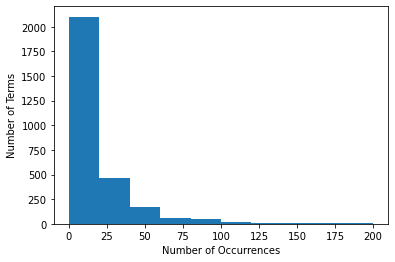

In [80]:
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences')
plt.ylabel('Number of Terms');

In [81]:
# Re-tokenize words, recreate joined documents
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

Doc_ID
40    [boredom, set, long, start, angel, fallen, sta...
41    [people, mutter, enter, screening, angel, fall...
42    [ric, roman, waughs, angel, fallen, secret, se...
43    [certain, mindless, pleasure, fallen, movie, w...
44    [dont, need, olympus, fallen, andor, london, f...
Name: lemmas, dtype: object

## Get Lemmatized and Filtered Sentences

Removes the additional words 

In [82]:
corpus_df['sentences_lemmatized']=\
corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

In [83]:
corpus_df.head().T

Doc_ID,40,41,42,43,44
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,\nWho ARE all these people?\n\nThat was what...,Ric Roman Waughs Angel Has Fallen sees U.S. S...,There is a certain mindless pleasure in the Fa...,"No, you dont need to have seen Olympus Has F..."
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Student Name,KCM,KCM,KCM,KCM,KCM
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42,Action_Angel Has Fallen_N_43,Action_Angel Has Fallen_N_44
Doc_ID,40,41,42,43,44
raw_sentences,[Boredom sets in long before the start of Ange...,[\nWho ARE all these people?\n\nThat was wha...,[Ric Roman Waughs Angel Has Fallen sees U.S. ...,[There is a certain mindless pleasure in the F...,"[No, you dont need to have seen Olympus Has ..."


## Review Documents By Movie Title

In [84]:
print(corpus_df['Movie Title'].unique())

['Angel Has Fallen' 'Inception' 'No Time To Die' 'Taken' 'Taxi'
 'Despicable Me 3' 'Dirty Grandpa' 'Holmes and Watson' 'Legally Blonde'
 'The Lost City' 'Drag me to hell' 'Fresh' 'It Chapter Two'
 'The Toxic Avenger' 'US' 'Batman' 'Equilibrium' 'Minority Report'
 'Oblivion' 'Pitch Black']


In [85]:
movie_df = corpus_df[corpus_df['Movie Title'] == 'Minority Report'].copy()
movie_df.head(3).T

Doc_ID,115,116,117
DSI_Title,RSV_Doc6_MinorityReport,RSV_Doc7_MinorityReport,RSV_Doc8_MinorityReport
Text,"Minority Report , directed by Steven Spielberg...",Once again this year we are graced with a futu...,"Set in the year 2054, Steven Spielberg's Minor..."
Submission File Name,RSV_Doc6_MinorityReport,RSV_Doc7_MinorityReport,RSV_Doc8_MinorityReport
Student Name,RSV,RSV,RSV
Genre of Movie,Sci-Fi,Sci-Fi,Sci-Fi
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Minority Report,Minority Report,Minority Report
Descriptor,Sci-Fi_Minority Report_N_115,Sci-Fi_Minority Report_N_116,Sci-Fi_Minority Report_N_117
Doc_ID,115,116,117
raw_sentences,"[Minority Report , directed by Steven Spielber...",[Once again this year we are graced with a fut...,"[Set in the year 2054, Steven Spielberg's Mino..."


## Knowledge Graph Extraction

In [86]:
corpus_text_sentences = [y for x in movie_df.raw_sentences for y in x]
example_sentence = nlp(corpus_text_sentences[5])
corpus_text_sentences[5]

'Spielberg is one of the more gifted members of a generation of studio filmmakers whose output in general has been exceedingly poor and forgettable.'

In [87]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]

100%|██████████| 532/532 [00:04<00:00, 107.60it/s]


In [88]:
entity_pairs

[['Steven screenplay', 'latest Steven Spielberg'],
 ['Washington who', 'infallibly  killings'],
 ['they', 'freezing  units'],
 ['own police force', 'trail'],
 ['event  that', 'also  marriage'],
 ['gifted studio output', 'gifted studio filmmakers'],
 ['He', 'effectively  theme'],
 ['themes', 'middle class Americans'],
 ['personal  wealth', 'American 2 society'],
 ['Minority Report', 'intriguing Philip K. elements'],
 ['expense', ''],
 ['filmmakers', 'ingenious  2054'],
 ['contemporary science imagination', 'only  people'],
 ['Minority which', 'social  creators'],
 ['crime', 'century'],
 ['', ''],
 ['', 'social  reality'],
 ['right wing crime', 'merely  consequences'],
 ['psychics', 'possible turning film'],
 ['who', 'offenses'],
 ['actual  events', 'themselves'],
 ['One', 'small  mercies'],
 ['preemptively  who', 'preemptively  everyone'],
 ['day  indeed!It', 'day  democracy'],
 ['much popcorn I', 'due  process'],
 ['Doris Kearns who', 'constitutional  Precrime'],
 ['idea', 'Rights?”’”S

### Create DataFrame (Source, Target, Edge)

In [89]:
relations = [get_relation(x) for x in corpus_text_sentences]   
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

### Knowledge Graph Preprocessing (Lowercase, Remove Empty Spaces)

In [90]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [91]:
kg_df.head(6).T

,0,1,2,3,4,5
source,steven screenplay,washington who,they,own police force,event that,gifted studio output
target,latest steven spielberg,infallibly killings,freezing units,trail,also marriage,gifted studio filmmakers
edge,is,eliminated in,apprehended,sets,abducted,is


In [92]:
len(corpus_text_sentences)

532

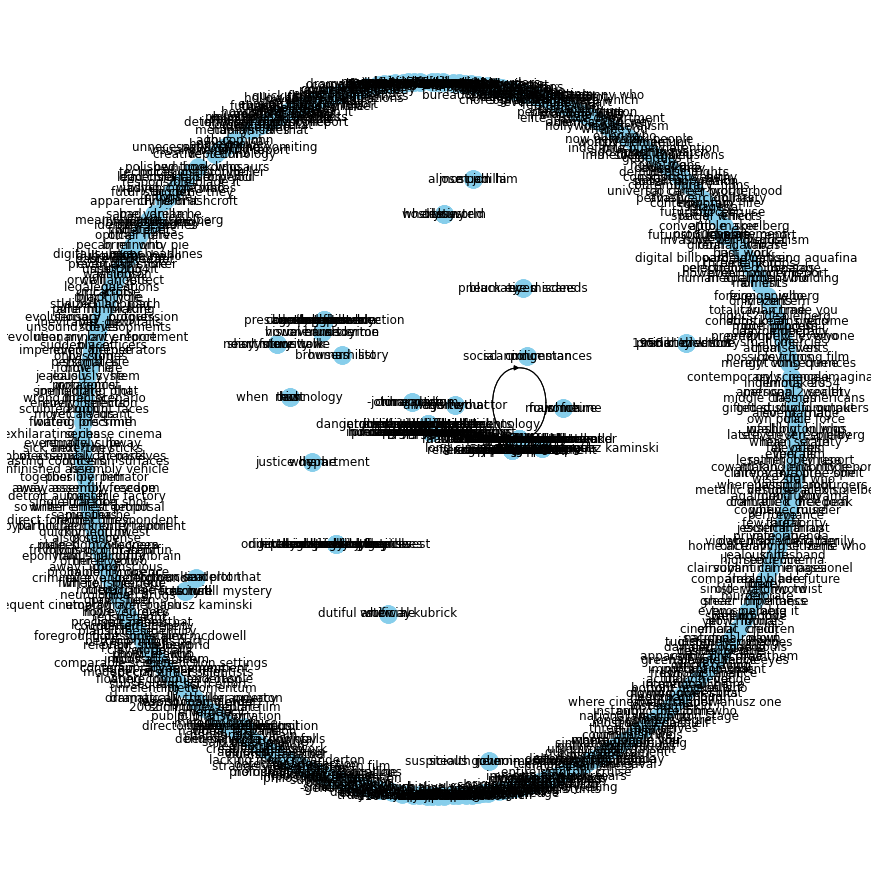

In [93]:
plot_graph(kg_df, use_circular=False)

## Recurrent Neural Network (RNN) Model Development

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/BidirectionalRNN.png?raw=true">

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

In [94]:
datafull=corpus_df.copy() 
datafull.reset_index(drop=True, inplace=True)
datafull.head().T

,0,1,2,3,4
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,\nWho ARE all these people?\n\nThat was what...,Ric Roman Waughs Angel Has Fallen sees U.S. S...,There is a certain mindless pleasure in the Fa...,"No, you dont need to have seen Olympus Has F..."
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Student Name,KCM,KCM,KCM,KCM,KCM
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42,Action_Angel Has Fallen_N_43,Action_Angel Has Fallen_N_44
Doc_ID,40,41,42,43,44
raw_sentences,[Boredom sets in long before the start of Ange...,[\nWho ARE all these people?\n\nThat was wha...,[Ric Roman Waughs Angel Has Fallen sees U.S. ...,[There is a certain mindless pleasure in the F...,"[No, you dont need to have seen Olympus Has ..."


In [95]:
datafull['Text'] = datafull['Text'].apply(lambda x :clean_doc(x))

## Preprocess DataSet 

In [96]:
data = datafull[['Text','Genre of Movie']].copy()

In [97]:
data['Genre of Movie'] = data['Genre of Movie'].astype("category")
data['Genre of Movie code'] = data['Genre of Movie'].cat.codes
data['Genre of Movie code'].tail().T

195    3
196    3
197    3
198    3
199    3
Name: Genre of Movie code, dtype: int8

In [98]:
features, targets = data['Text'], data['Genre of Movie code']
 
train_features, test_features, train_targets, test_targets = train_test_split(features
                                                                              ,targets
                                                                              ,test_size=0.20
                                                                              ,random_state=42
                                                                              ,shuffle = True
                                                                              ,stratify=targets)
data[["Genre of Movie","Genre of Movie code"]].value_counts()

Genre of Movie  Genre of Movie code
Action          0                      50
Comedy          1                      50
Horror          2                      50
Sci-Fi          3                      50
dtype: int64

## Create Datasets for Model Development

In [99]:
trainds, valds, testds = get_dataset_partitions_pd(data[['Text','Genre of Movie code']])
trainds.shape, valds.shape, testds.shape

((160, 2), (20, 2), (20, 2))

## Convert DataFrame to TensorFlow DataSet

In [100]:
# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Text'].values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Genre of Movie code'].values, tf.int64),
  ) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Genre of Movie code'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Text'].values, tf.string)
) 
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Genre of Movie code'].values, tf.int64),
)

## Create DataSets (X=Preprocessed Text, Y=Encoded Categories)

In [101]:
train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

## Create Data Pipelines (Batching, Shuffling, and Optimizing)

In [102]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds = val_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Text                 200 non-null    object  
 1   Genre of Movie       200 non-null    category
 2   Genre of Movie code  200 non-null    int8    
dtypes: category(1), int8(1), object(1)
memory usage: 2.3+ KB


## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.TextVectorization</b><br>
   https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
    </div>

In [104]:
VOCAB_SIZE=5000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)

In [105]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

5000

In [106]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 's', 'the', 'film', 'i', '’', 'movie', 'one', 'like',
       'time', 'it', 'get', 'make', 'nt', 'character', 'even', 'but',
       'scene', 'much'], dtype='<U16')

In [107]:
vocab[-20:]

array(['vhs', 'vertical', 'verge', 'verbally', 'venture', 'veneer',
       'vector', 'variety', 'vanity', 'vanilla', 'van', 'valuable',
       'vain', 'vacant', 'uziel', 'uttering', 'utopian', 'urban', 'upper',
       'unwieldy'], dtype='<U16')

## Example of Encoded Words

In [108]:
encoded_example = encoder('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

array([   1,  185,    1,  835, 3028,    1,  120,  120])

In [109]:
len(encoder.get_vocabulary())

5000

In [110]:
encoder(data['Text'][0])

<tf.Tensor: shape=(507,), dtype=int64, numpy=
array([   1,   57,   85,  111,  442,  229,  334,    5,  111, 2083,    7,
       2967,   44, 2525,   59, 2160,  216,   59,  663,    9, 2132, 2666,
       2973,    1,  223,    1,    1, 3244,    1,    5,  714,    1, 3102,
        369, 1618,    1,  685,    5,   72,   59,  755, 3837,    9,   56,
         23,    7,    1,    1, 4461,  116,   72, 1342,  116,  204,  116,
          1,   11,  529,    8,  489, 1058, 3329,  108,    1,  103, 4076,
       1696,   98,   40, 1199,  254,  442,  229,  334,  635,  454,   35,
         40, 1199,   31,  309,    7,   82, 1206,  624,   40, 1353,  242,
         84, 2502,   31, 1261,  477,  413,    1,  292,  198,   35,  283,
       1696, 1309,  154,  529,  589, 2525, 2558,  108,   58,  182,  589,
        820,  739,   92, 3032, 3299,  354,  982,   64,  478,  901, 1367,
       3378,    1,  284,  526,  283,  204,    5, 3144, 1367,    1, 4677,
         29,   42, 2870,    1, 1139, 2667,  317, 1179, 1008, 1926,    5,
     

In [111]:
for example, label in train_ds.take(1):
  print('texts: ', example.numpy()[:1])
  print()

texts:  [b'The theatrical release Batman celebrates 30 year year hold product era regard cinematic entertainment . A brief prologue introduces u Wayne family cutting present day . Gotham City mayor Borg ( Lee Wallace ) want city safer . This task fall upon District Attorney Harvey Dent ( Billy Dee Williams ) Police Commissioner Jim Gordon ( Pat Hingle ) . Unbeknownst , Gotham new vigilante parading around town form Batman ( Bruce Wayne ) . Amid rumor Dark Knight , photojournalist Vicki Vale ( Kim Basinger ) reporter Alexander Knox ( Robert Wuhl ) start investigate existence . Corrupt police officer working mob bring rise Jack Napier aka Joker ( Jack Nicholson ) . In running theme many Batman villain , Napier fall chemical go mad . Ever playmate , Bruce start relationship Vicki whole work thing always manages get way . I won\xc3\x95t really spoil rest it\xc3\x95s 30 year . Once upon time , would best film depicting Dark Knight . This longer case Christopher Nolan\xc3\x95s phenomenal tri

## Build RNN Sequential Model 

<div class="alert alert-block alert-info">
    <b>tf.keras.layers</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers
    </div>

In [126]:
num_classes=4 # updated from 5
model=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')  
])

In [127]:
model.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
              ,metrics=['accuracy'])

In [128]:
%%time
history = model.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
53/53 [==============================] - 22s 169ms/step - loss: 1.3857 - accuracy: 0.2264 - val_loss: 1.3893 - val_accuracy: 0.3333
Epoch 2/200
53/53 [==============================] - 4s 84ms/step - loss: 1.2244 - accuracy: 0.4843 - val_loss: 1.9116 - val_accuracy: 0.2222
Epoch 3/200
53/53 [==============================] - 4s 84ms/step - loss: 0.9530 - accuracy: 0.6038 - val_loss: 1.8176 - val_accuracy: 0.2222
CPU times: user 33.6 s, sys: 827 ms, total: 34.4 s
Wall time: 30.7 s


## Model Performance Test Accuracy

In [129]:
test_loss, test_acc = model.evaluate(val_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 0s 31ms/step - loss: 1.8237 - accuracy: 0.2222
Test Loss: 1.823682188987732
Test Accuracy: 0.2222222238779068


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

In [130]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [131]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,1.386,0.226,1.389,0.333
1,1.224,0.484,1.912,0.222
2,0.953,0.604,1.818,0.222


In [132]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

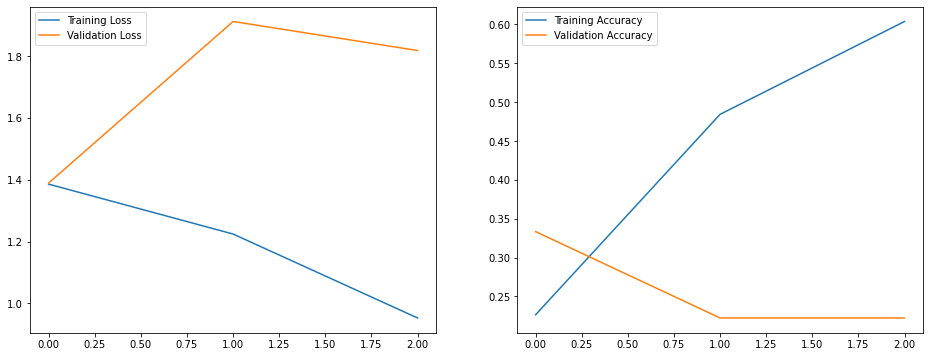

In [133]:
plt.figure(figsize=(16, 6))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Confusion Matrix Post Model Performance Analysis

In [134]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)

6/6 [==============================] - 4s 37ms/step


In [135]:
CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

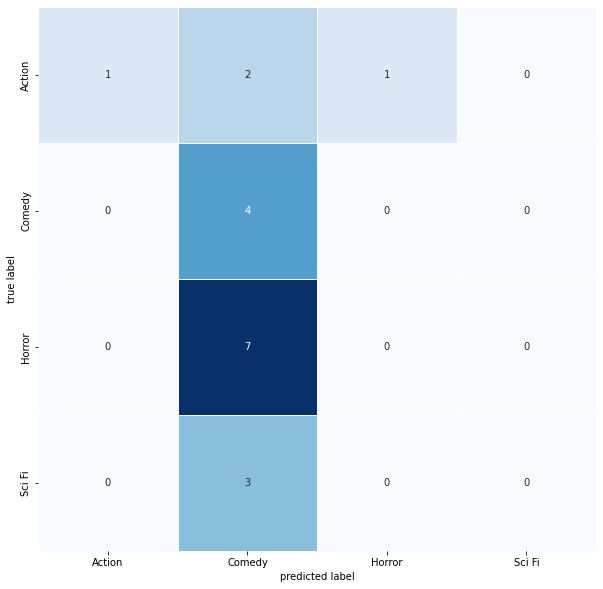

In [136]:
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST)

In [137]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [138]:
# preds2

In [139]:
df2 = pd.DataFrame(preds2[0:15]
                  ,columns = CLASSES_LIST).T
df2.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Action,0.32%,1.77%,0.19%,1.42%,1.23%,21.72%,5.27%,1.88%,3.78%,0.25%,64.30%,4.21%,0.43%,1.05%,0.99%
Comedy,88.44%,68.41%,92.46%,75.79%,71.09%,28.41%,43.77%,71.78%,64.10%,91.18%,3.32%,44.10%,86.10%,76.56%,74.64%
Horror,4.38%,9.29%,3.79%,8.82%,8.13%,32.95%,13.58%,10.01%,13.70%,3.99%,23.56%,11.85%,5.29%,7.83%,7.50%
Sci Fi,6.87%,20.53%,3.56%,13.96%,19.54%,16.92%,37.37%,16.33%,18.41%,4.58%,8.82%,39.84%,8.18%,14.56%,16.87%


## RNN Model Architecture

In [140]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          320000    
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                      